Exploring [Applied Geospatial Datascience Chapter 5](https://github.com/PacktPublishing/Applied-Geospatial-Data-Science-with-Python/blob/main/Chapter05/Chapter%205%20-%20Exploratory%20Data%20Visualization_vf.ipynb).

In [136]:
import pandas as pd
import geopandas as gpd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sbn
import geoplot as gplt
import geoplot.crs as gcrs

In [2]:
data_path = 'AirBnB Listings EDA/data/'

In [42]:
# Load AirBnB listings data (from http://insideairbnb.com/get-the-data/)
listings = pd.read_csv(data_path + 'listings.csv.gz', compression='gzip')

# Subset to columns of interest
listings_sub = listings[['id','property_type','neighbourhood_cleansed', 'neighbourhood_group_cleansed','price','latitude','longitude']].copy()

In [43]:
# Convert price strings to floats to enable math-ing them
listings_sub['price'] = listings_sub['price'].replace("[$,]", "", regex=True).astype(float)

In [44]:
listings_sub.head()

,id,property_type,neighbourhood_cleansed,neighbourhood_group_cleansed,price,latitude,longitude
0,9357,Entire rental unit,Hell's Kitchen,Manhattan,175.0,40.76724,-73.98664
1,10452,Private room in rental unit,Bedford-Stuyvesant,Brooklyn,90.0,40.68294,-73.95682
2,11943,Private room in home,Flatbush,Brooklyn,150.0,40.63702,-73.96327
3,12192,Private room in rental unit,East Village,Manhattan,70.0,40.72296,-73.98383
4,12937,Private room in townhouse,Long Island City,Queens,165.0,40.74757,-73.94571


In [45]:
listings_sub.describe()

,id,price,latitude,longitude
count,3.916000e+04,39160.000000,39160.000000,39160.000000
mean,2.932430e+17,205.995480,40.729372,-73.945897
std,3.943340e+17,466.662167,0.056645,0.054958
min,2.595000e+03,0.000000,40.500314,-74.251907
25%,1.991531e+07,76.000000,40.688880,-73.982819
50%,4.574172e+07,130.000000,40.726470,-73.953960
75%,7.354150e+17,220.000000,40.762632,-73.926260
max,1.015028e+18,30000.000000,40.911380,-73.713650


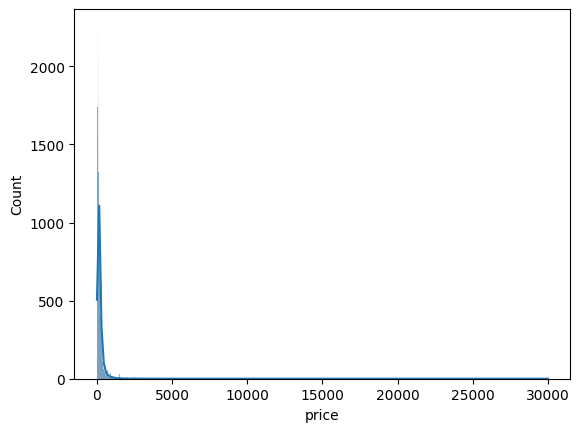

In [50]:
# Show the skewedness of the price distribution
sbn.histplot(listings_sub['price'], kde=True)
plt.show()

In [54]:
# Now let's begin exploratory SPATIAL data analysis.
# Convert the DataFrame into a GeoDataFrame
listings_sub_gdf = gpd.GeoDataFrame(
    listings_sub, 
    geometry=gpd.points_from_xy(listings_sub.longitude, listings_sub.latitude, crs=4326)
)

We want to see a **heatmap** depicting the number of listings in each borough bin

**First pass**: Let's just graph a KDE isochrone plot of listings' spatial density on top of a map of the boroughs. No actual histogram 'bins' to define the heatmap bin boundaries. 

<GeoAxes: xlabel='None', ylabel='None'>

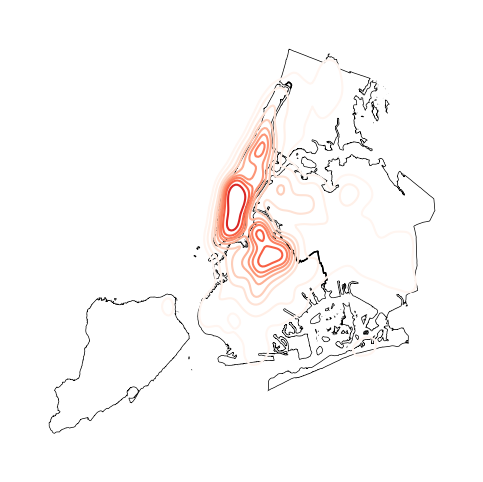

In [78]:
# Define the boroughs as spatial heatmap bins
boroughs = gpd.read_file(data_path + r"borough_boundaries.zip")
boroughs = boroughs.to_crs(4326)

# geoplot has a convient way to show points on a basemap (implicitly picking the bounds)
#ax = gplt.webmap(listings_sub_gpd,projection=gcrs.WebMercator())
#gplt.pointplot(listings_sub_gpd, ax=ax)

ax = gplt.kdeplot(listings_sub_gpd,
    clip=boroughs.geometry,
    cmap='Reds',
    projection=gcrs.WebMercator()
)
# Plotting the heatmap on top of the boroughs for context
gplt.polyplot(boroughs, ax=ax, zorder=1)

# We see that most listings are in lower/mid manhattan and north brooklyn

**Second pass**: Define spatially-defined bins for histogram (really this will be a 'chloropleth', not a histogram). Use census tract boundaries for our spatial histogram bins.

In [116]:
NY_tracts_path = "https://www2.census.gov/geo/tiger/TIGER2021/TRACT/tl_2021_36_tract.zip"
NY_Tracts = gpd.read_file(NY_tracts_path).to_crs(4326)

In [118]:
NY_Tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,36,047,069601,36047069601,696.01,Census Tract 696.01,G5020,S,456923,47776,+40.6271699,-073.9153676,"POLYGON ((-73.91860 40.63210, -73.91692 40.631..."
1,36,047,069602,36047069602,696.02,Census Tract 696.02,G5020,S,688168,172866,+40.6227610,-073.9092489,"POLYGON ((-73.91747 40.62151, -73.91699 40.621..."
2,36,047,079801,36047079801,798.01,Census Tract 798.01,G5020,S,129680,0,+40.6600109,-073.9587186,"POLYGON ((-73.96077 40.66173, -73.95704 40.661..."
3,36,047,079802,36047079802,798.02,Census Tract 798.02,G5020,S,106366,0,+40.6579906,-073.9613711,"POLYGON ((-73.96281 40.66050, -73.96201 40.660..."
4,36,047,105801,36047105801,1058.01,Census Tract 1058.01,G5020,S,418443,0,+40.6492205,-073.8805957,"POLYGON ((-73.88550 40.65309, -73.88502 40.653..."


In [120]:
# Filter the census tracts to those in the New York CBSA (Core-Based Statistical Area)
# to make it more managable and relevant
cbsa_path = 'https://www2.census.gov/geo/tiger/TIGER2021/CBSA/tl_2021_us_cbsa.zip'
cbsas = gpd.read_file(cbsa_path)
NY_cbsa = cbsas[cbsas['GEOID']=='35620']

# Here we use the spatial intersection operation
mask = NY_Tracts.intersects(NY_cbsa.loc[620,'geometry'])
NY_Tracts_subset = NY_Tracts.loc[mask].to_crs(4326)

In [114]:
# Now we aggregate the listings into the CBSA bins
# Do so with the spatial join operation
NY_Tracts_sj = gpd.sjoin(NY_Tracts_subset, listings_sub_gdf, how='left', predicate='contains')

# Filter to relevant columns
NY_Tracts_sj = NY_Tracts_sj[['GEOID','price','geometry']]

# Reduce to mean price per bin
NY_Tracts_Agg = NY_Tracts_sj.dissolve(by='GEOID', aggfunc='mean')

In [132]:
NY_Tracts_Agg.head()
# Remove MultiPolygon rows that break choropleth
multipolygon_mask = NY_Tracts_Agg['geometry'].apply(lambda x: x.geom_type != 'MultiPolygon')
NY_Tracts_Agg = NY_Tracts_Agg[multipolygon_mask]

<Axes: >

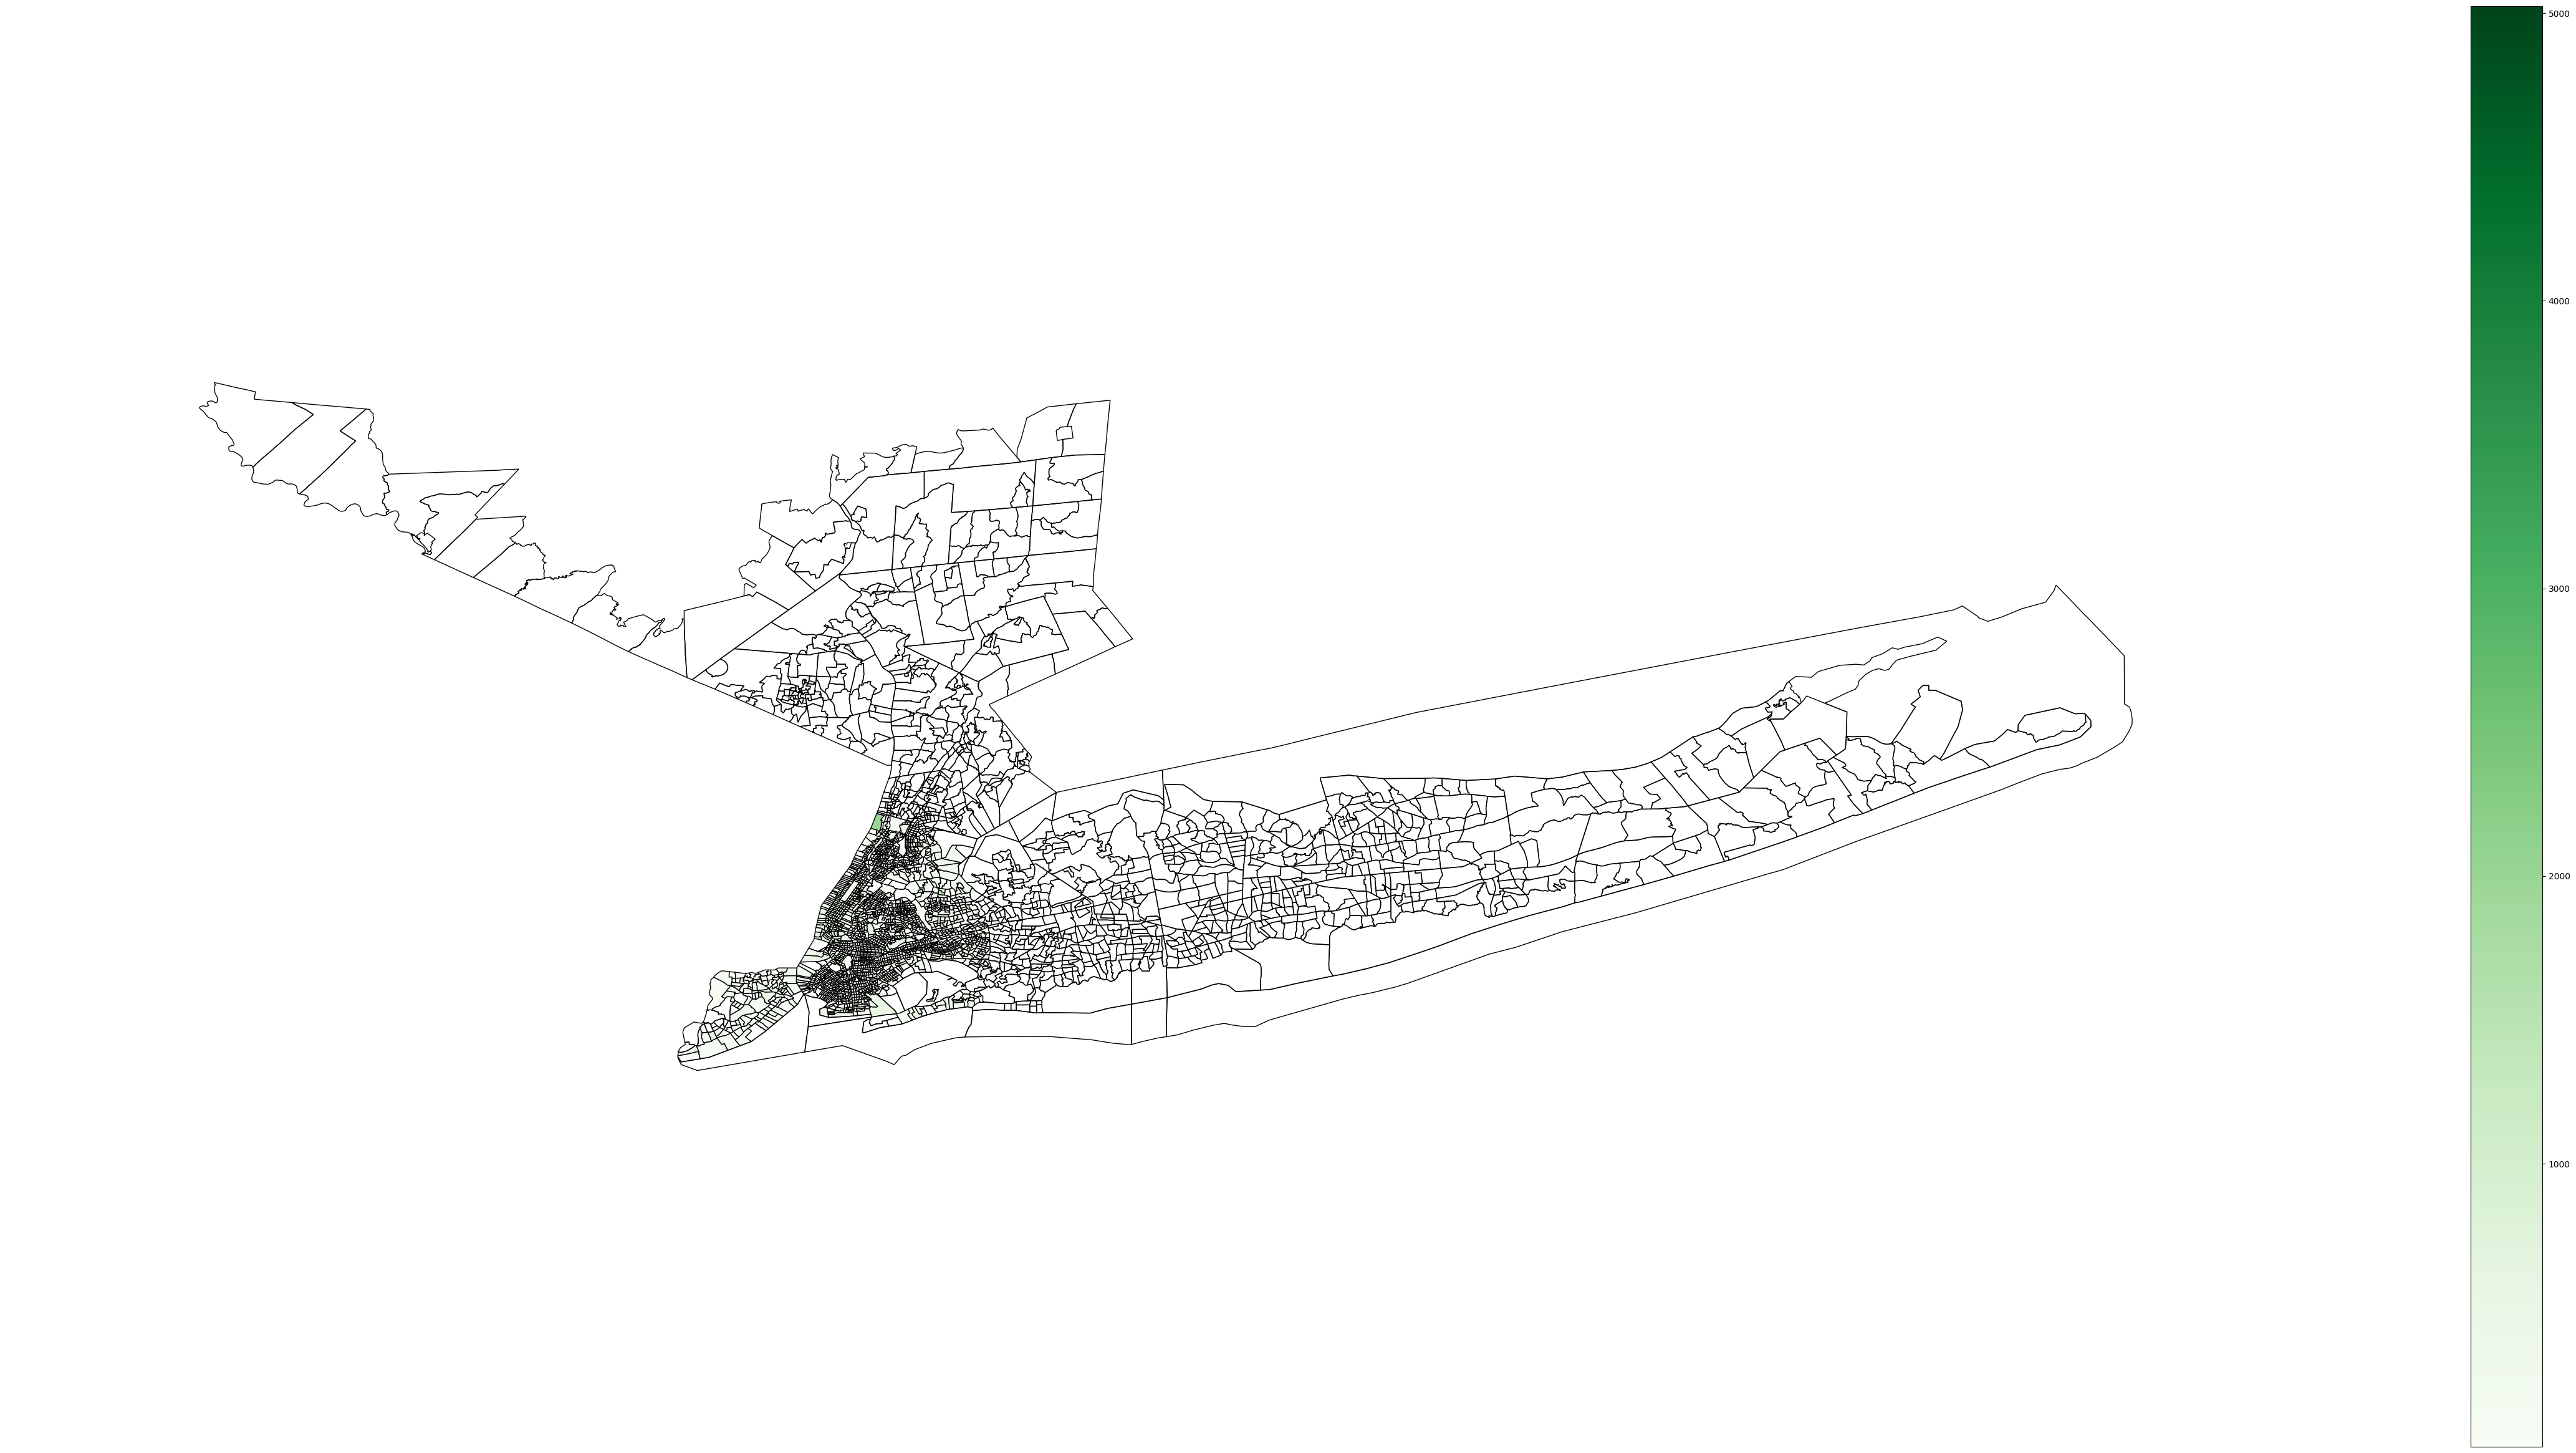

In [135]:
gplt.choropleth(NY_Tracts_Agg, hue="price", cmap="Greens", legend=True, figsize=(60,30))

Above we see the problem with our right-skewed price data. The high price outliers means the full range of color is mostly wasted, and our image doesn't have much visually useful info.

So, we should remove the outliers (anything more than 1 standard deviation above the mean)

In [137]:
mean = statistics.mean(NY_Tracts_Agg['price'].dropna())
std = statistics.stdev(NY_Tracts_Agg['price'].dropna())

NY_Tracts_Agg_no_outliers = NY_Tracts_Agg[NY_Tracts_Agg['price'] < mean+std]

<Axes: >

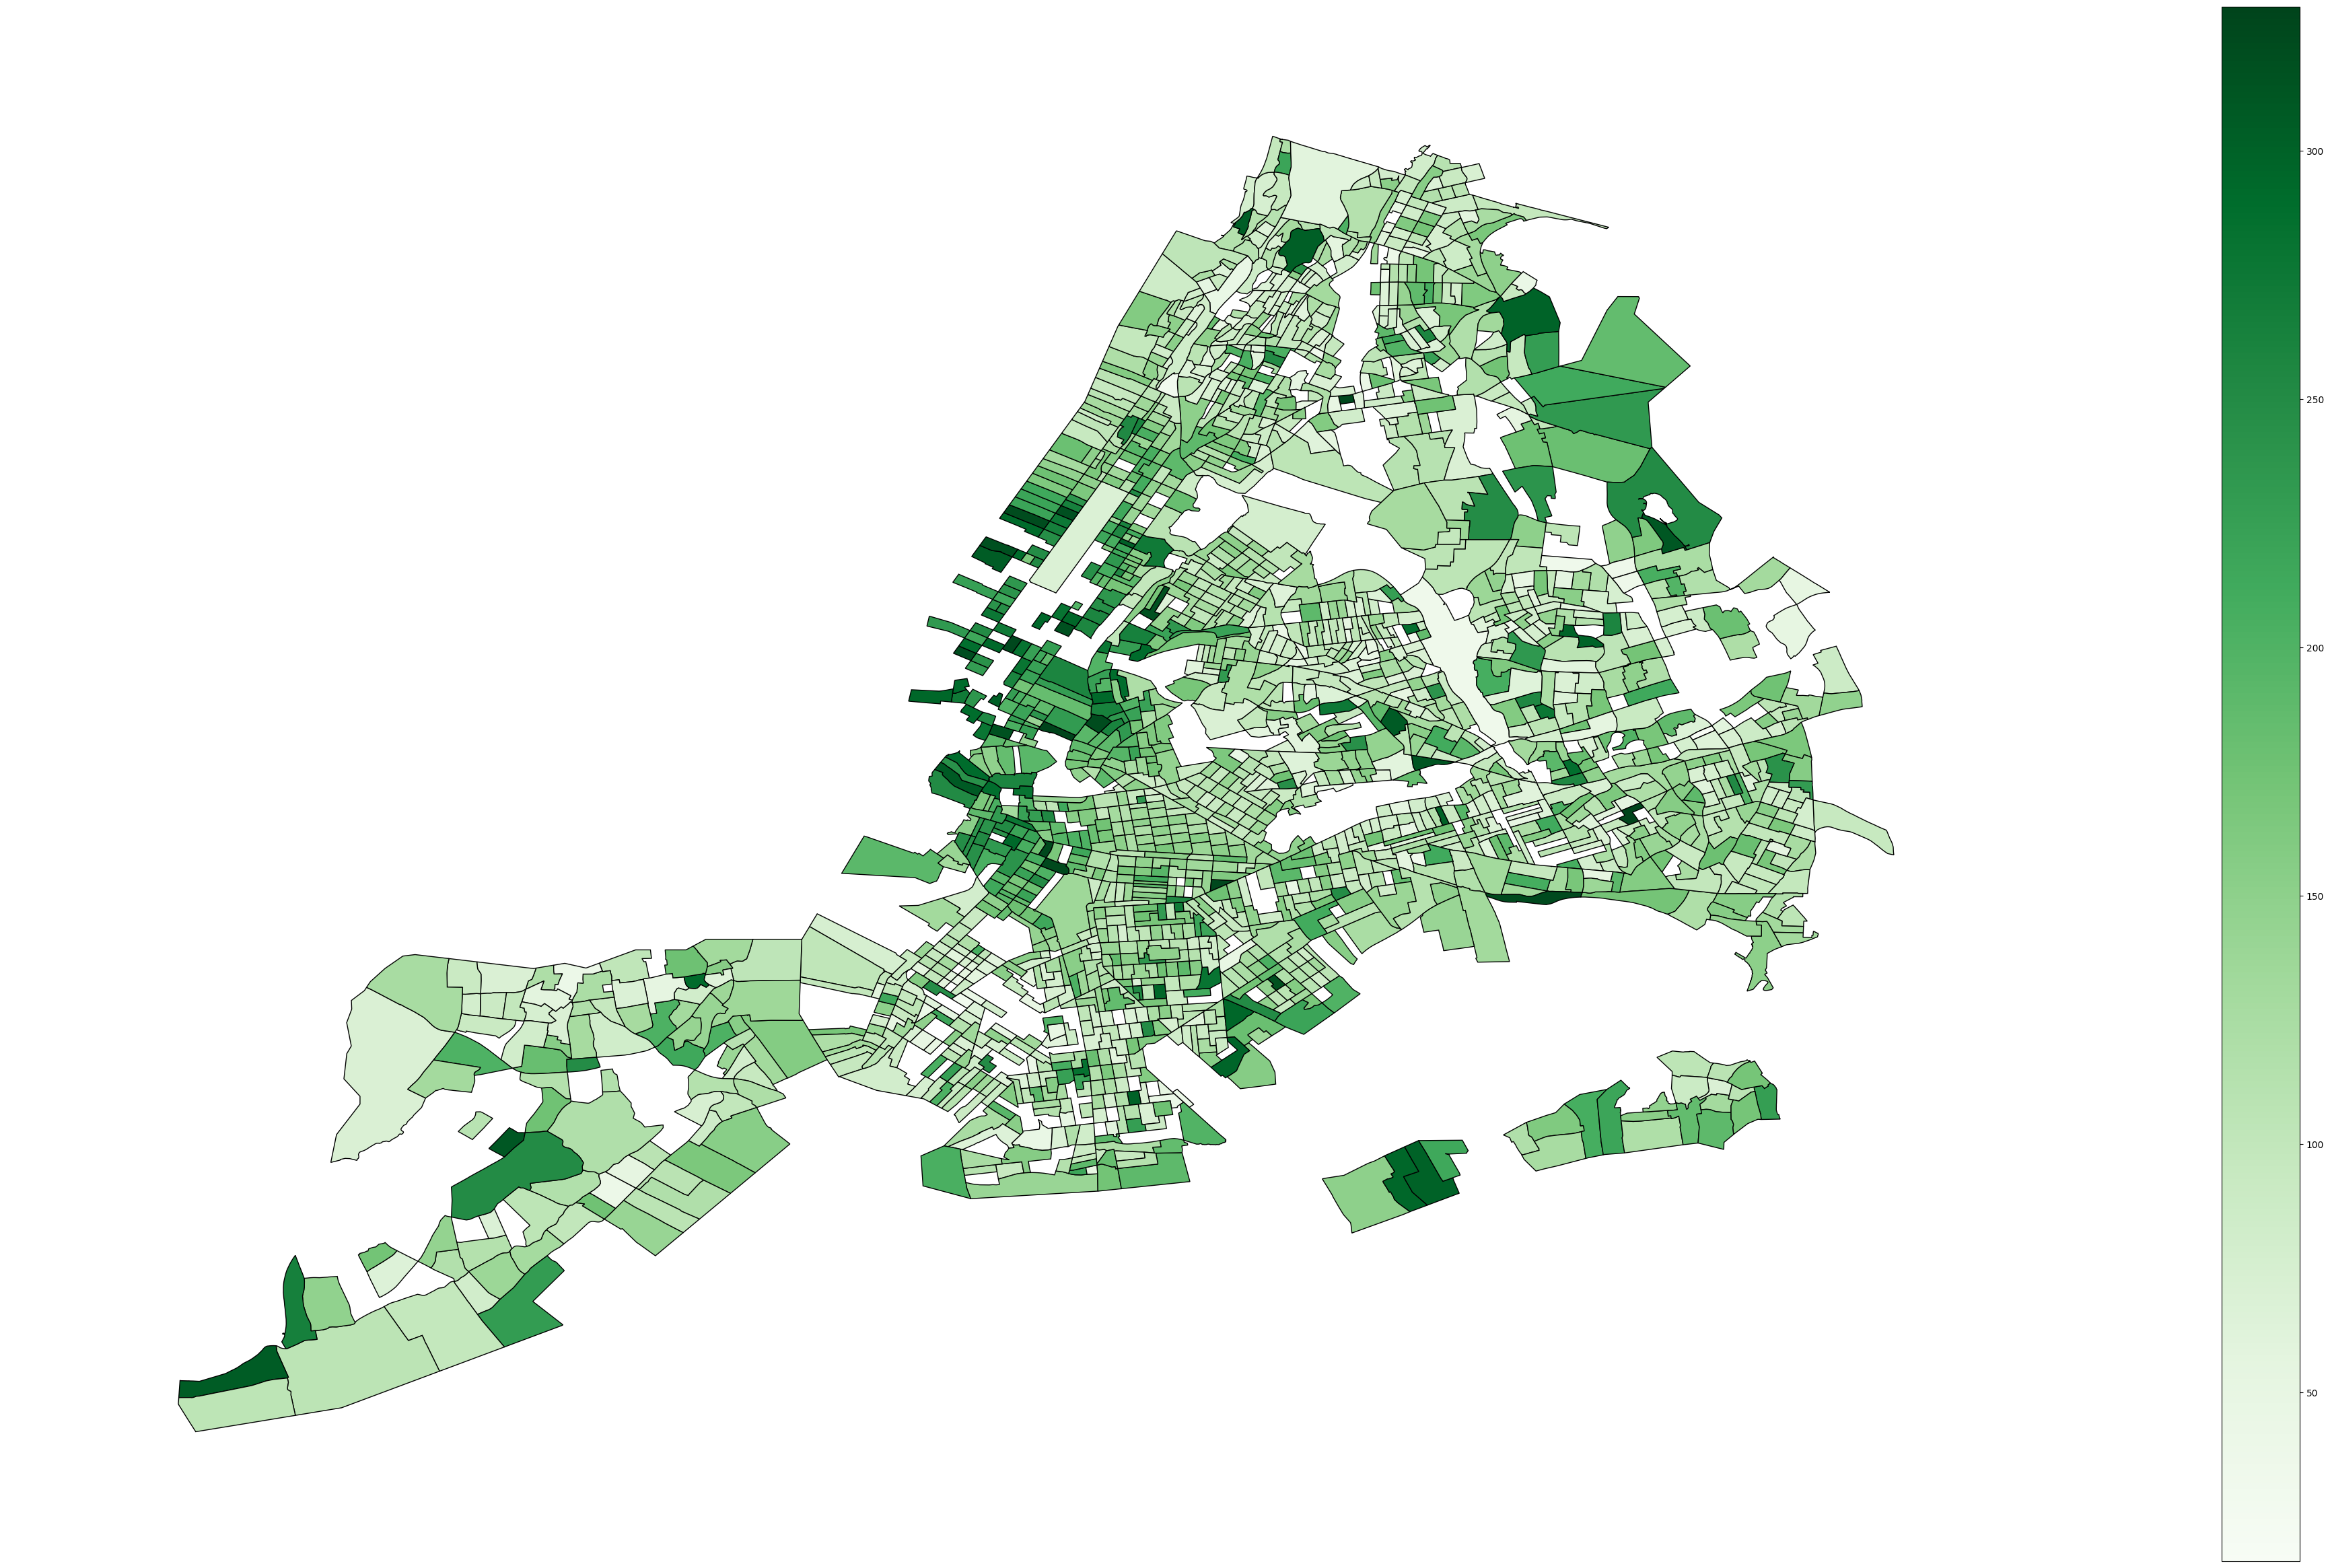

In [138]:
gplt.choropleth(NY_Tracts_Agg_no_outliers, hue="price", cmap="Greens", legend=True, figsize=(60,30))